<a href="https://colab.research.google.com/github/gabrieladamasceno/Model_Attacks/blob/main/ORAN_Random_Forest_All_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/ORAN/Network_Dataset.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [30]:
import pandas as pd


print(f"Total de colunas: {len(encoded.columns)}\n")
print(encoded.columns.tolist())

Total de colunas: 26

['uid', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'history', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'ip_proto', 'http_trans_depth', 'attack_category', 'attack_type', 'files_total_bytes', 'is_GET_mthd', 'http_status_error', 'is_file_transfered', 'traffic_type']


In [31]:
import pandas as pd

# Ver todos os tipos de ataque (categorias amplas)
print("Categorias de ataque:")
print(encoded['attack_category'].unique())

# Contar ocorrência de cada categoria
print("\nContagem por categoria:")
print(encoded['attack_category'].value_counts())

# Ver todos os tipos específicos de ataque
print("\nTipos específicos de ataque:")
print(encoded['attack_type'].unique())

# Contar ocorrência de cada tipo específico
print("\nContagem por tipo:")
print(encoded['attack_type'].value_counts())

Categorias de ataque:
['ddos' 'bruteforce' 'probe' 'web' 'dos' 'benign']

Contagem por categoria:
attack_category
dos           632507
ddos          420282
web           288304
probe         183293
benign        170865
bruteforce     28566
Name: count, dtype: int64

Tipos específicos de ataque:
['tcp_ack' 'syn' 'icmp' 'slowloris' 'udp' 'ssh' 'ftp' 'portscan_tcp'
 'os_fingerprinting' 'portscan_udp' 'http_flood' 'dir_bruteforce' 'benign'
 'xss' 'sql_injection']

Contagem por tipo:
attack_type
syn                  506451
http_flood           254314
udp                  227408
tcp_ack              199304
benign               170865
portscan_tcp         100000
slowloris             94887
os_fingerprinting     62957
dir_bruteforce        28566
icmp                  24739
portscan_udp          20336
ssh                   14902
ftp                   13664
xss                    3661
sql_injection          1763
Name: count, dtype: int64


In [32]:
pip install imbalanced-learn


In [33]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [34]:
!pip install gputil


In [35]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [36]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

In [37]:
import psutil
import time
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
import subprocess
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K

# ===== Monitor Resource =====
def monitor_resource_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_usage_mb = memory_info.rss / (1024 * 1024)
    return cpu_percent, memory_usage_mb

def calcular_energia(cpu_usage, freq_ghz, tempo_exec_s, theta=1.0, z=1e-27):
    freq_hz = freq_ghz * 1e9
    carga = cpu_usage * theta * freq_hz
    energia_joules = z * (carga ** 3) * tempo_exec_s
    return energia_joules

# ===== Training =====
class ResourceMonitor(Callback):
    def on_train_begin(self, logs=None):
        self.cpu_usage = []
        self.memory_usage = []
        self.energy_usage = []
        self.start_time = time.time()
        print("\n[Start of Training]")

    def on_epoch_begin(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        print(f"\n[Epoch {epoch + 1} - Start] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

    def on_epoch_end(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        frequencia_cpu_ghz = 2.0
        tempo_execucao_epoca = time.time() - self.start_time
        print(f"[Epoch {epoch + 1} - End] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

        gc.collect()
        K.clear_session()

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        avg_cpu = np.mean(self.cpu_usage)
        avg_mem = np.mean(self.memory_usage)

        frequencia_cpu_ghz = 2.0

        energia = calcular_energia(avg_cpu, frequencia_cpu_ghz, total_time)

        print("\n[End of Training]")
        print(f"Total time: {total_time:.2f} seconds")
        print(f"Average CPU usage (Training): {avg_cpu:.2f}%")
        print(f"Average memory usage (Training): {avg_mem:.2f} MB")
        print(f"Estimated energy consumption: {energia:.2f} Joules")

        self.total_time = total_time
        self.avg_cpu = avg_cpu
        self.avg_mem = avg_mem
        self.energia = energia

        self._plot_usage()

    def _plot_usage(self):
        epochs = list(range(1, len(self.cpu_usage) + 1))

        plt.figure(figsize=(14, 5))

        # CPU
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.cpu_usage, marker='o', linestyle='-', color='tab:blue', label='CPU Usage')
        plt.xlabel("Epoch")
        plt.ylabel("CPU Usage (%)")
        plt.title("CPU Consumption (Train)")
        plt.legend()
        plt.grid(True)

        # Memória
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.memory_usage, marker='o', linestyle='-', color='tab:red', label='Memory Usage')
        plt.xlabel("Epoch")
        plt.ylabel("Memory (MB)")
        plt.title("Memory Consumption (Train)")
        plt.legend()
        plt.grid(True)


        plt.tight_layout()
        plt.savefig("resource_usage_train.png")
        plt.show()
        plt.clf()
        plt.close()


# ===== Prediction/Test =====
def monitor_test_prediction(model, X_test):
    cpu_usage_test = []
    memory_usage_test = []

    print("\n[Start of Prediction/Test]")
    start_time = time.time()

    step_size = max(1, len(X_test) // 10)
    for i in range(0, len(X_test), step_size):
        end_i = min(i + step_size, len(X_test))
        monitor_cpu, monitor_mem = monitor_resource_usage()
        cpu_usage_test.append(monitor_cpu)
        memory_usage_test.append(monitor_mem)
        _ = model.predict(X_test[i:end_i])

    total_time_test = time.time() - start_time
    avg_cpu_test = np.mean(cpu_usage_test)
    avg_mem_test = np.mean(memory_usage_test)

    frequencia_cpu_ghz = 2.0

    # Energy
    energia_test = calcular_energia(avg_cpu_test, frequencia_cpu_ghz, total_time_test)

    print("\n[End of Prediction/Test]")
    print(f"Total time: {total_time_test:.2f} seconds")
    print(f"Average CPU usage (Test): {avg_cpu_test:.2f}%")
    print(f"Average memory usage (Test): {avg_mem_test:.2f} MB")
    print(f"Estimated energy consumption: {energia_test:.2f} Joules")

    # Graphs
    plt.figure(figsize=(14, 5))

    # CPU
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(cpu_usage_test) + 1), cpu_usage_test, marker='o', linestyle='-', color='tab:blue', label='CPU Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("CPU Usage (%)")
    plt.title("CPU Consumption (Test)")
    plt.legend()
    plt.grid(True)

    # Memory
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(memory_usage_test) + 1), memory_usage_test, marker='o', linestyle='-', color='tab:red', label='Memory Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("Memory (MB)")
    plt.title("Memory Consumption (Test)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("resource_usage_test.png")
    plt.show()
    plt.clf()
    plt.close()

    return {
    'total_time': total_time_test,
    'avg_cpu': avg_cpu_test,
    'avg_mem': avg_mem_test,
    'energia': energia_test
    }

resource_monitor = ResourceMonitor()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [38]:
def monitor_train_generic(model, X_train, y_train, model_name="model"):
    print(f"\n[Start of Training - {model_name}]")
    process = psutil.Process(os.getpid())

    # Start
    cpu_start = process.cpu_percent(interval=None)
    mem_start = process.memory_info().rss / (1024 * 1024)
    start_time = time.time()

    model.fit(X_train, y_train)

    # End
    cpu_end = process.cpu_percent(interval=None)
    mem_end = process.memory_info().rss / (1024 * 1024)
    end_time = time.time()

    total_time = end_time - start_time
    avg_cpu = (cpu_start + cpu_end) / 2
    avg_mem = (mem_start + mem_end) / 2
    freq_ghz = 2.0

    # Energy
    energia = calcular_energia(avg_cpu, freq_ghz, total_time)

    print(f"[End of Training - {model_name}]")
    print(f"Time: {total_time:.2f}s")
    print(f"CPU: {avg_cpu:.2f}%")
    print(f"Memory: {avg_mem:.2f} MB")
    print(f"Energy: {energia:.2e} Joules")

    return {
        'total_time': total_time,
        'avg_cpu': avg_cpu,
        'avg_mem': avg_mem,
        'energia': energia
    }

In [39]:
print(encoded['traffic_type'].unique())

[1 0]


In [40]:
# Criar label binária: 0 = benign, 1 = ataque
encoded['Label'] = encoded['traffic_type'].apply(lambda x: 0 if x == 0 else 1)

# Conferir
print(encoded[['traffic_type', 'Label']].head(10))
print("\nDistribuição das classes:")
print(encoded['Label'].value_counts())

   traffic_type  Label
0             1      1
1             1      1
2             1      1
3             1      1
4             1      1
5             1      1
6             1      1
7             1      1
8             1      1
9             1      1

Distribuição das classes:
Label
1    1552952
0     170865
Name: count, dtype: int64


In [41]:
pip install catboost


====== Zero-Day: tcp_ack ======
Total tcp_ack in the original dataset: 199304
  Zero-days removed from training: 159722
  Zero-day in the original test: 39582
  Test full total: 344764

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 264.30s
CPU: 50.00%
Memory: 3170.17 MB
Energy: 2.64e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.47 seconds
Average CPU usage (Test): 0.79%
Average memory usage (Test): 3178.43 MB
Estimated energy consumption: 9.79 Joules


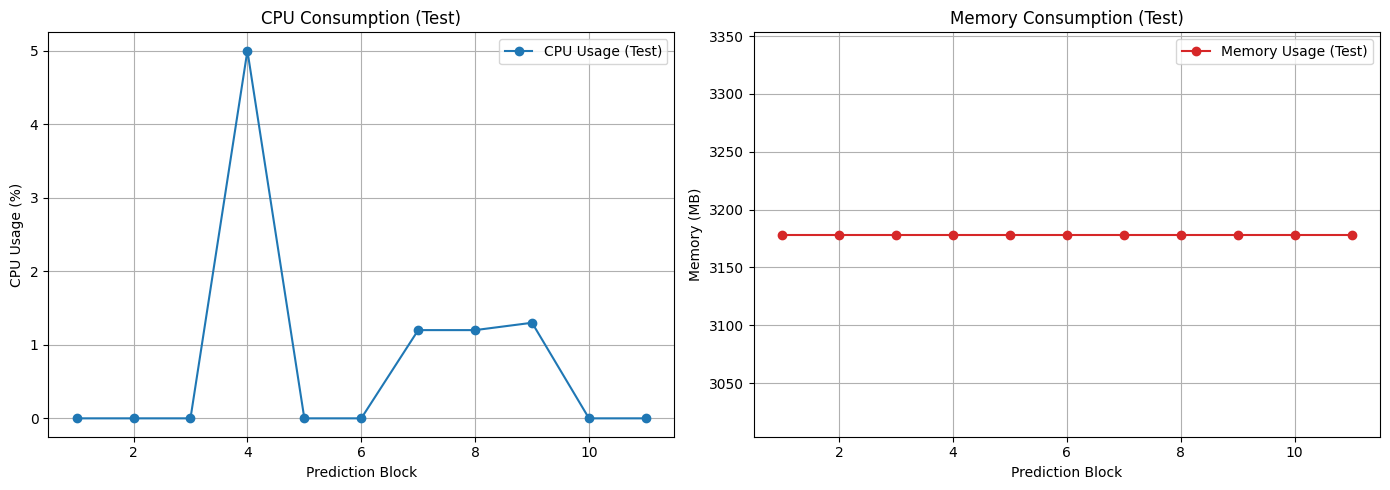


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.30 seconds
Average CPU usage (Test): 1.12%
Average memory usage (Test): 3178.43 MB
Estimated energy consumption: 14.53 Joules


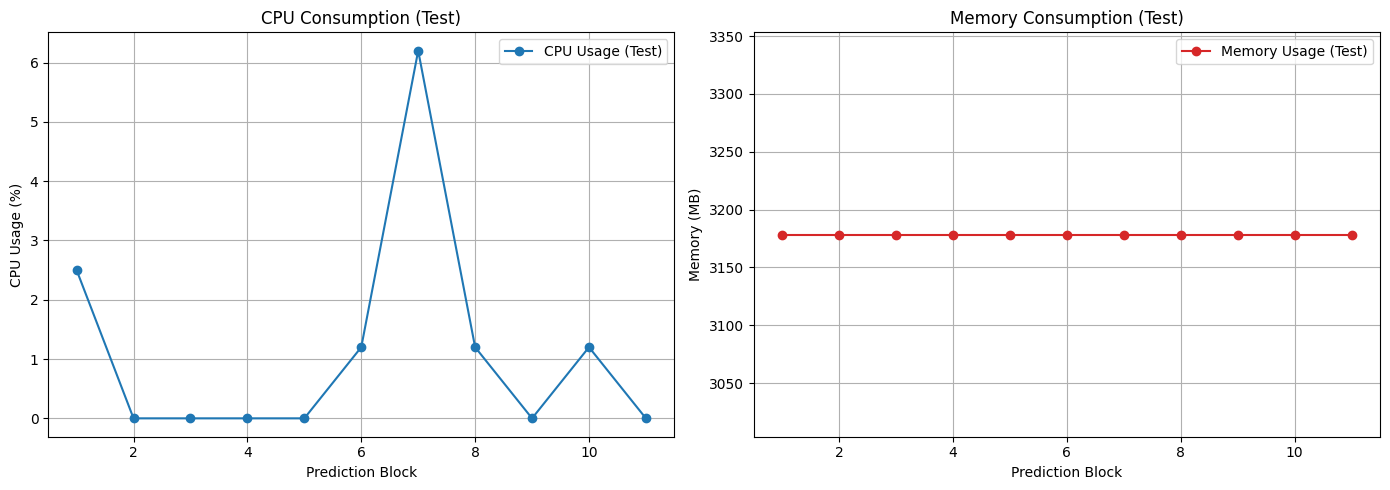

ROC FULL=0.9963
PR FULL=0.9996

====== Zero-Day: syn ======
Total syn in the original dataset: 506451
  Zero-days removed from training: 405095
  Zero-day in the original test: 101356
  Test full total: 344764

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 195.13s
CPU: 50.00%
Memory: 2992.89 MB
Energy: 1.95e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.45 seconds
Average CPU usage (Test): 0.35%
Average memory usage (Test): 2992.90 MB
Estimated energy consumption: 0.81 Joules


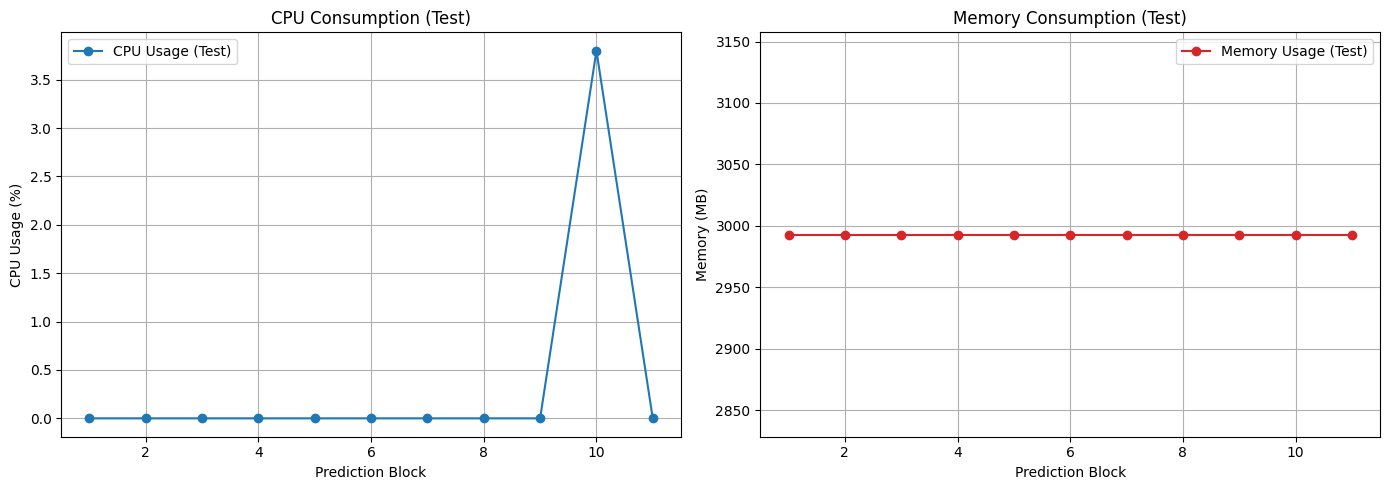


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.48 seconds
Average CPU usage (Test): 11.91%
Average memory usage (Test): 2992.91 MB
Estimated energy consumption: 20019.93 Joules


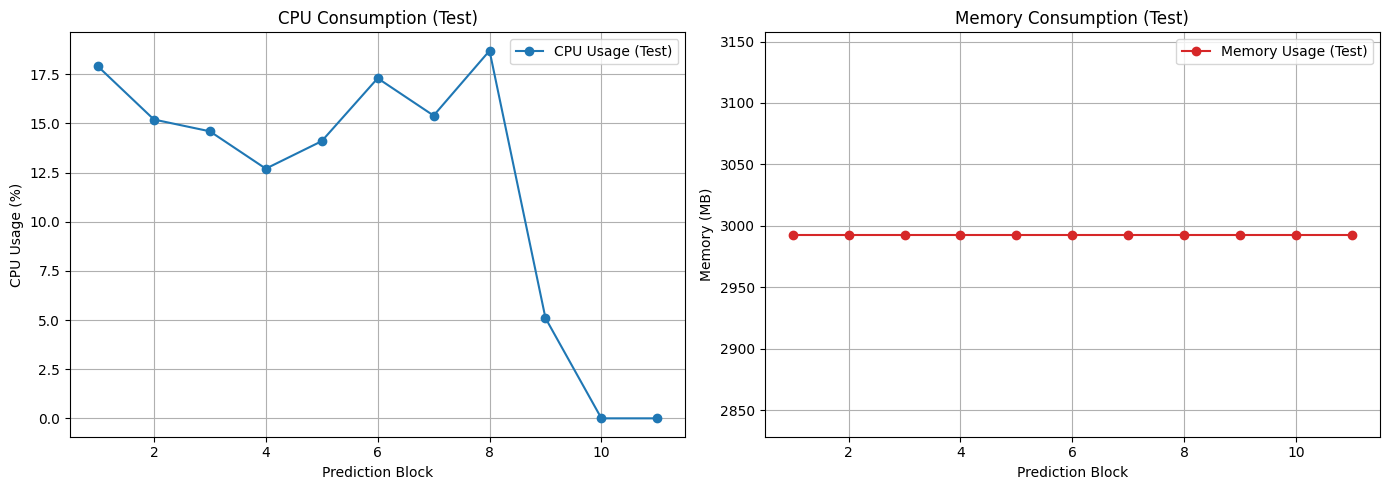

ROC FULL=0.9962
PR FULL=0.9996

====== Zero-Day: icmp ======
Total icmp in the original dataset: 24739
  Zero-days removed from training: 19756
  Zero-day in the original test: 4983
  Test full total: 344764

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 300.55s
CPU: 50.00%
Memory: 3242.33 MB
Energy: 3.01e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.49 seconds
Average CPU usage (Test): 0.90%
Average memory usage (Test): 3251.71 MB
Estimated energy consumption: 14.49 Joules


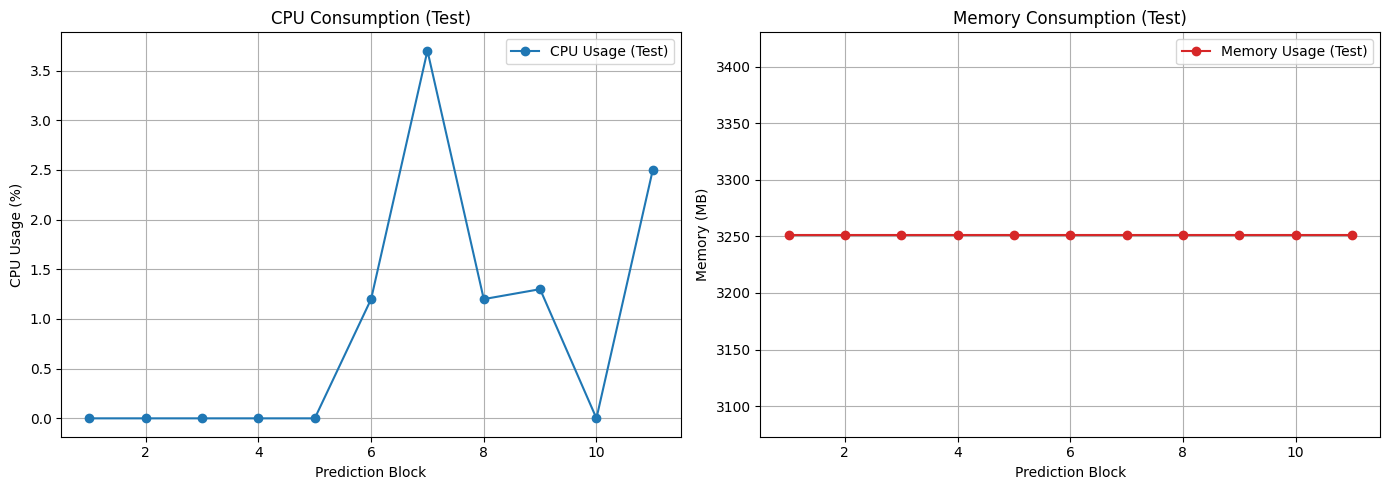


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.21 seconds
Average CPU usage (Test): 0.69%
Average memory usage (Test): 3251.71 MB
Estimated energy consumption: 3.18 Joules


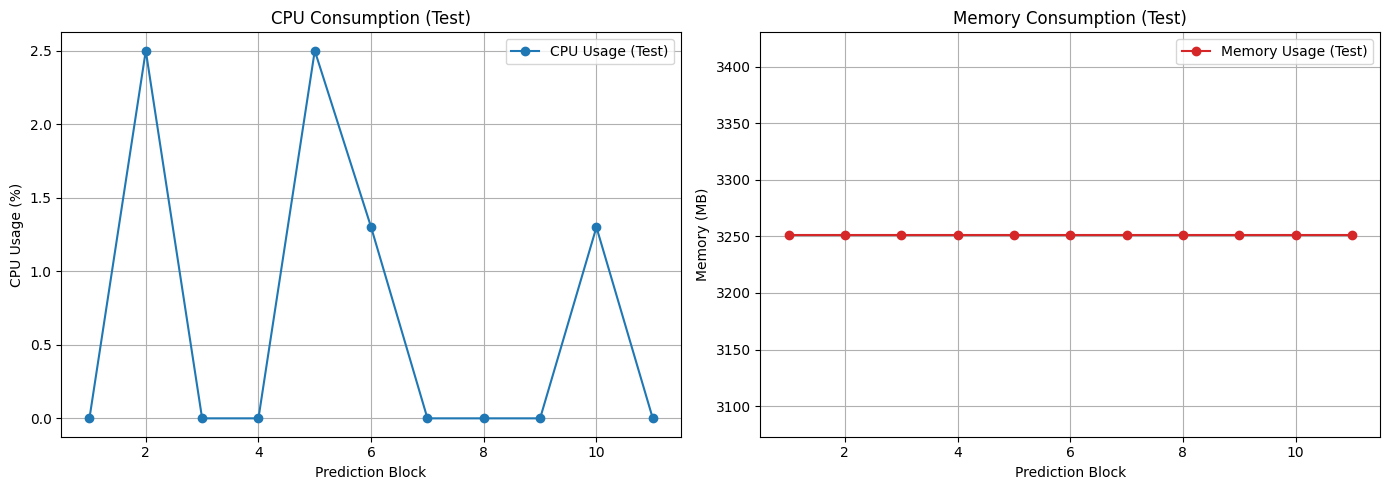

ROC FULL=0.9963
PR FULL=0.9996

====== Zero-Day: slowloris ======
Total slowloris in the original dataset: 94887
  Zero-days removed from training: 75934
  Zero-day in the original test: 18953
  Test full total: 344764

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 281.78s
CPU: 50.00%
Memory: 3283.69 MB
Energy: 2.82e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.51 seconds
Average CPU usage (Test): 5.69%
Average memory usage (Test): 3283.73 MB
Estimated energy consumption: 3696.84 Joules


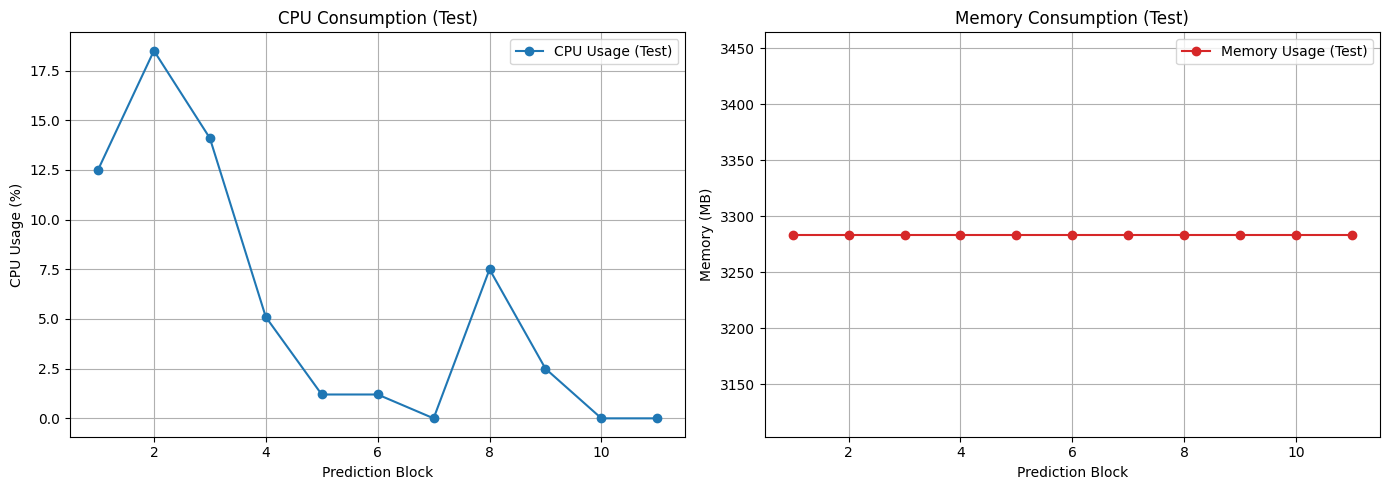


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.25 seconds
Average CPU usage (Test): 1.02%
Average memory usage (Test): 3283.73 MB
Estimated energy consumption: 10.53 Joules


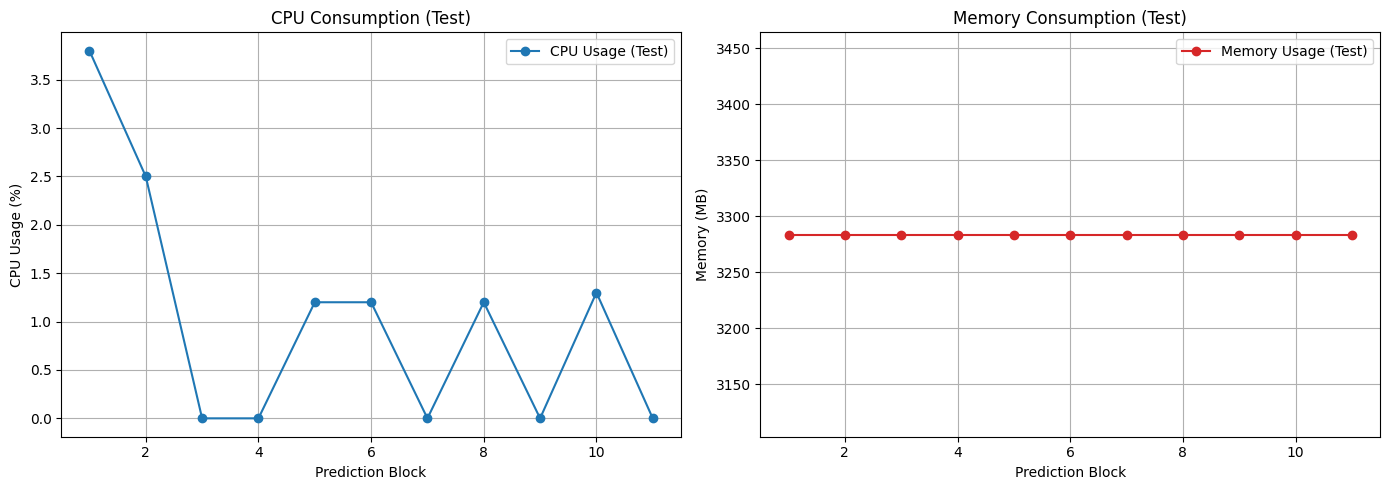

ROC FULL=0.9960
PR FULL=0.9996

====== Zero-Day: udp ======
Total udp in the original dataset: 227408
  Zero-days removed from training: 181655
  Zero-day in the original test: 45753
  Test full total: 344764

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 262.82s
CPU: 50.00%
Memory: 3130.75 MB
Energy: 2.63e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.45 seconds
Average CPU usage (Test): 1.59%
Average memory usage (Test): 3130.78 MB
Estimated energy consumption: 79.03 Joules


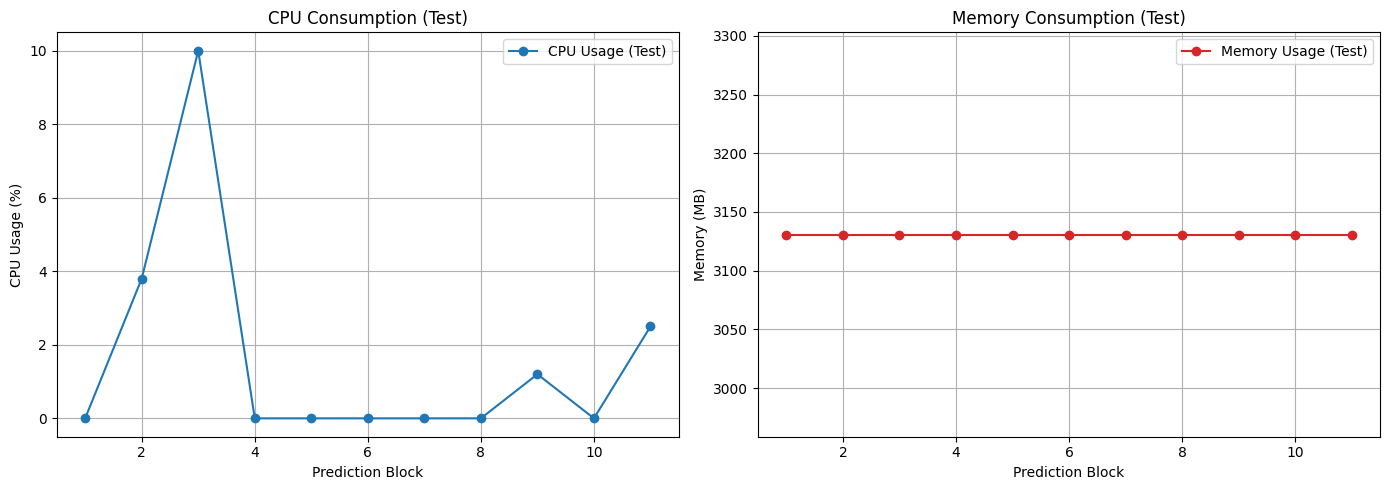


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.34 seconds
Average CPU usage (Test): 0.45%
Average memory usage (Test): 3130.78 MB
Estimated energy consumption: 1.01 Joules


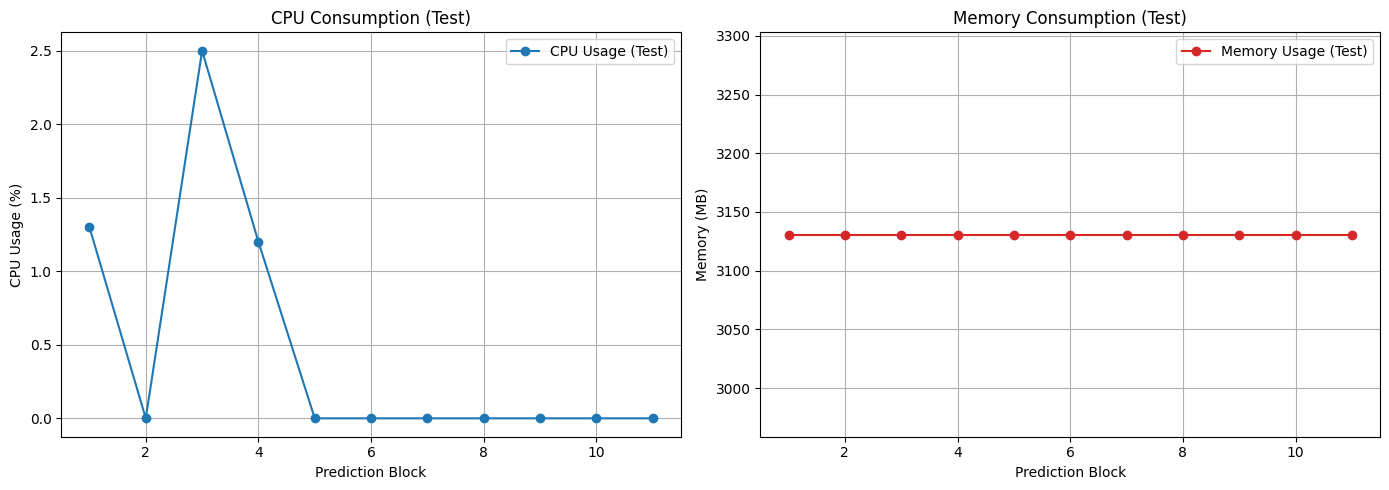

ROC FULL=0.9956
PR FULL=0.9995

====== Zero-Day: ssh ======
Total ssh in the original dataset: 14902
  Zero-days removed from training: 12009
  Zero-day in the original test: 2893
  Test full total: 344764

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 302.52s
CPU: 50.00%
Memory: 3271.07 MB
Energy: 3.03e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.45 seconds
Average CPU usage (Test): 2.61%
Average memory usage (Test): 3271.11 MB
Estimated energy consumption: 347.99 Joules


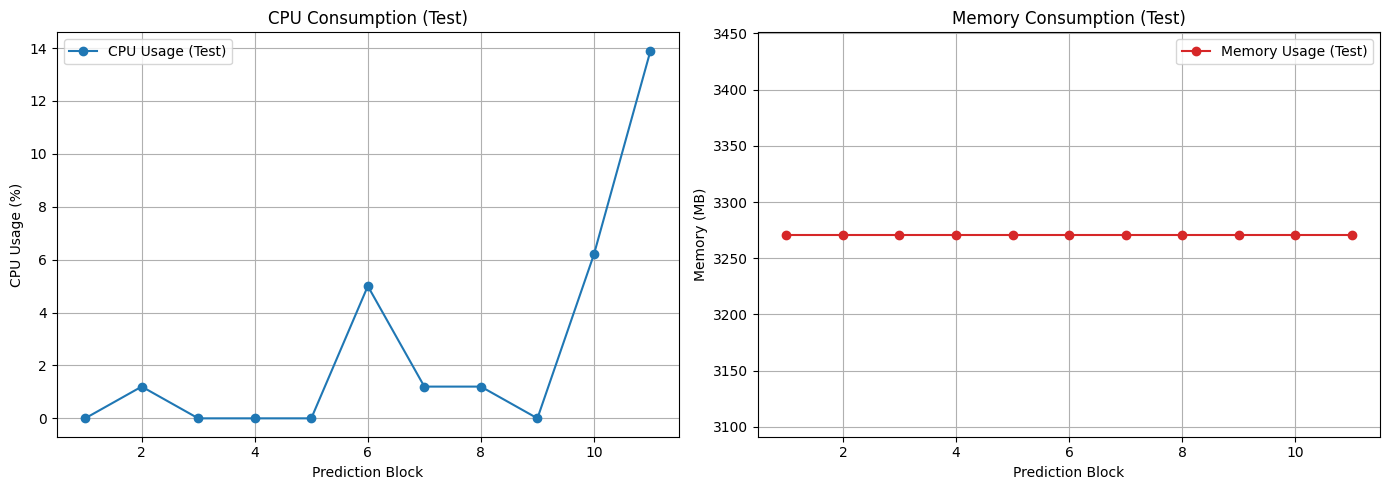


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.20 seconds
Average CPU usage (Test): 11.02%
Average memory usage (Test): 3271.11 MB
Estimated energy consumption: 12866.51 Joules


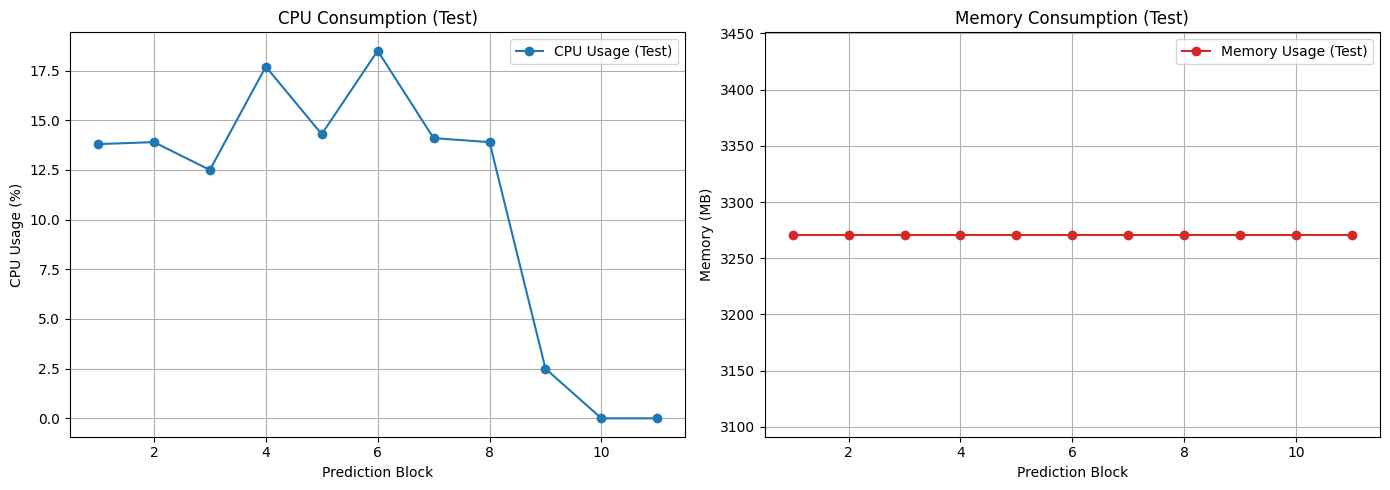

ROC FULL=0.9961
PR FULL=0.9996

====== Zero-Day: ftp ======
Total ftp in the original dataset: 13664
  Zero-days removed from training: 10894
  Zero-day in the original test: 2770
  Test full total: 344764

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 283.46s
CPU: 50.00%
Memory: 3361.34 MB
Energy: 2.83e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.43 seconds
Average CPU usage (Test): 1.02%
Average memory usage (Test): 3361.38 MB
Estimated energy consumption: 20.52 Joules


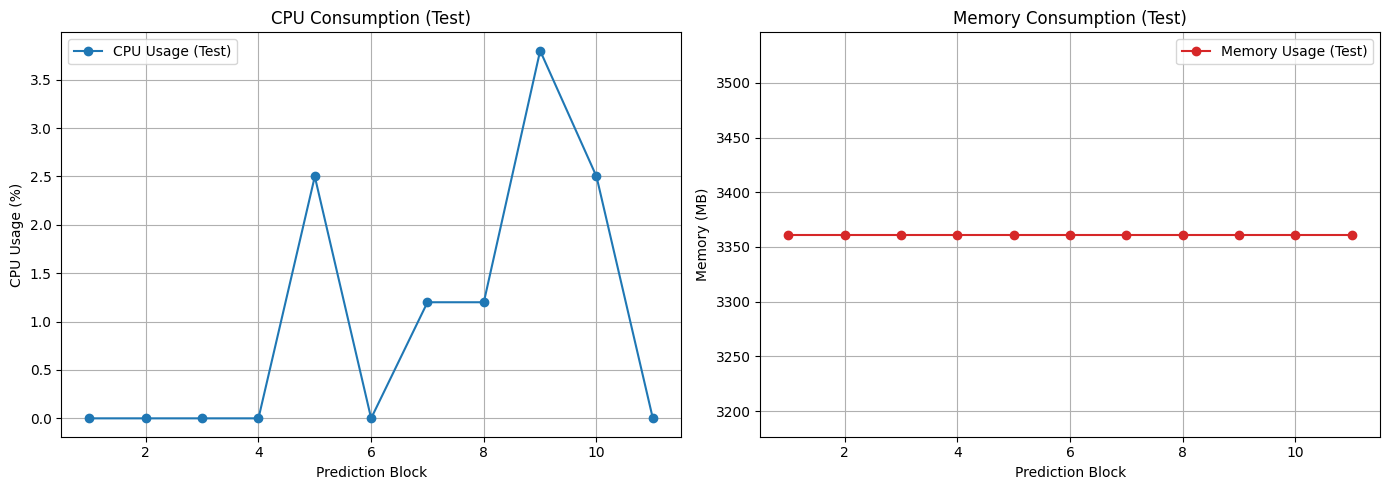


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.08 seconds
Average CPU usage (Test): 1.00%
Average memory usage (Test): 3361.38 MB
Estimated energy consumption: 8.65 Joules


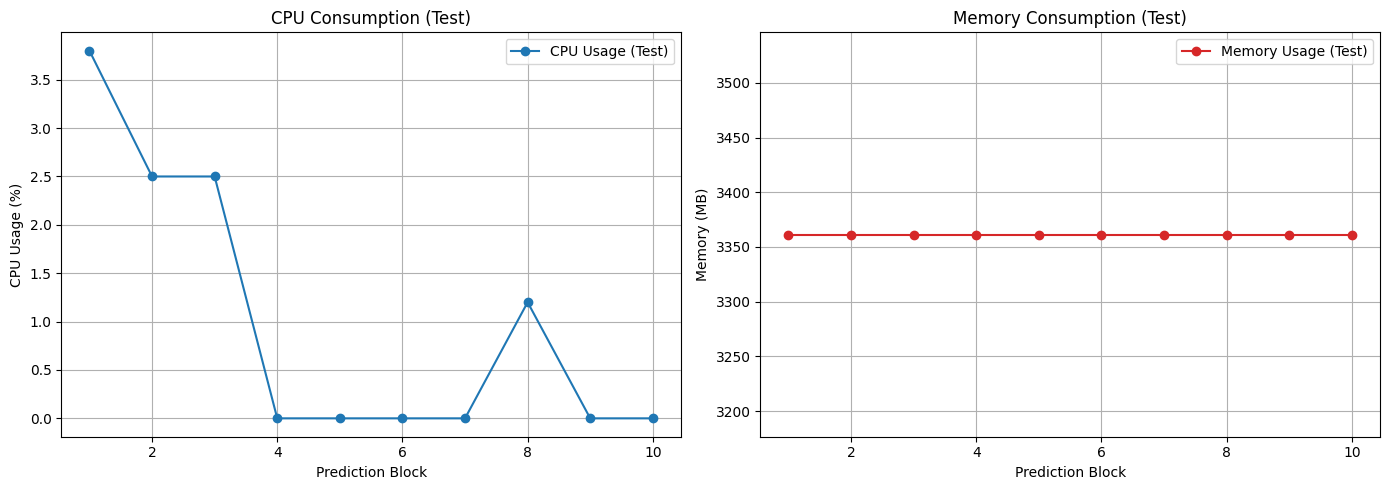

ROC FULL=0.9963
PR FULL=0.9996

====== Zero-Day: portscan_tcp ======
Total portscan_tcp in the original dataset: 100000
  Zero-days removed from training: 80192
  Zero-day in the original test: 19808
  Test full total: 344764

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 288.90s
CPU: 50.00%
Memory: 3260.97 MB
Energy: 2.89e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.50 seconds
Average CPU usage (Test): 9.48%
Average memory usage (Test): 3261.02 MB
Estimated energy consumption: 17058.94 Joules


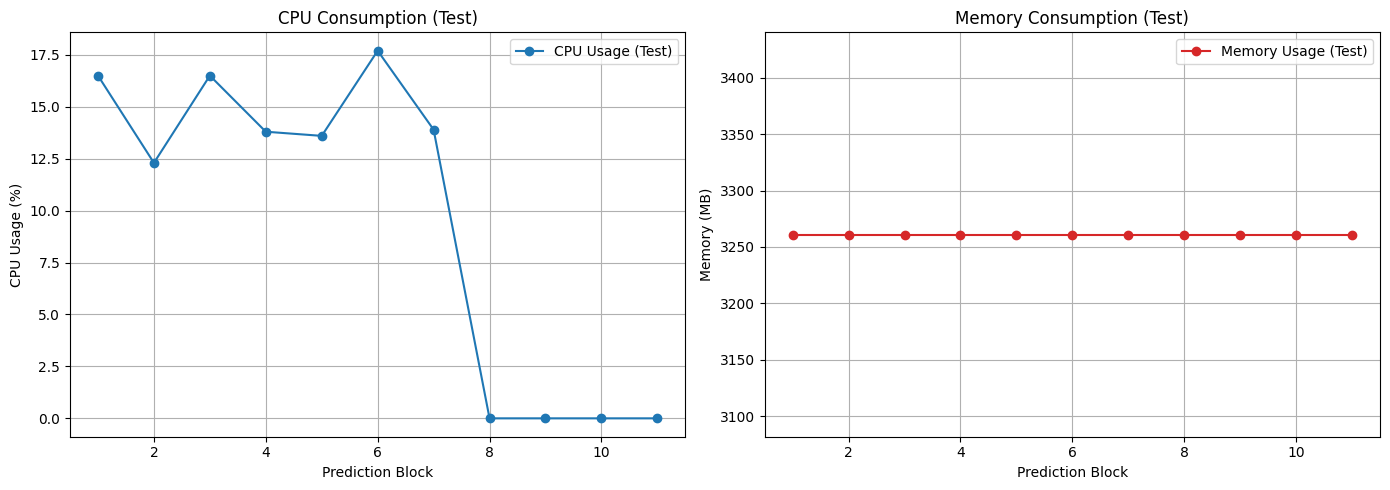


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.23 seconds
Average CPU usage (Test): 1.03%
Average memory usage (Test): 3261.02 MB
Estimated energy consumption: 10.68 Joules


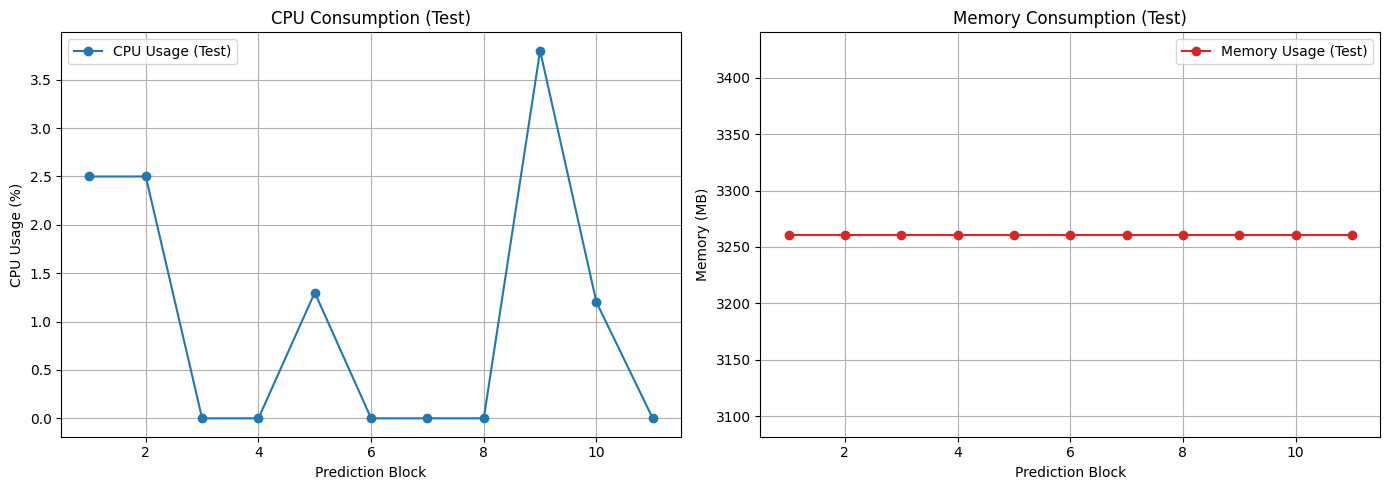

ROC FULL=0.9964
PR FULL=0.9996

====== Zero-Day: os_fingerprinting ======
Total os_fingerprinting in the original dataset: 62957
  Zero-days removed from training: 50265
  Zero-day in the original test: 12692
  Test full total: 344764

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 295.99s
CPU: 50.00%
Memory: 3284.92 MB
Energy: 2.96e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.53 seconds
Average CPU usage (Test): 8.64%
Average memory usage (Test): 3284.95 MB
Estimated energy consumption: 13020.77 Joules


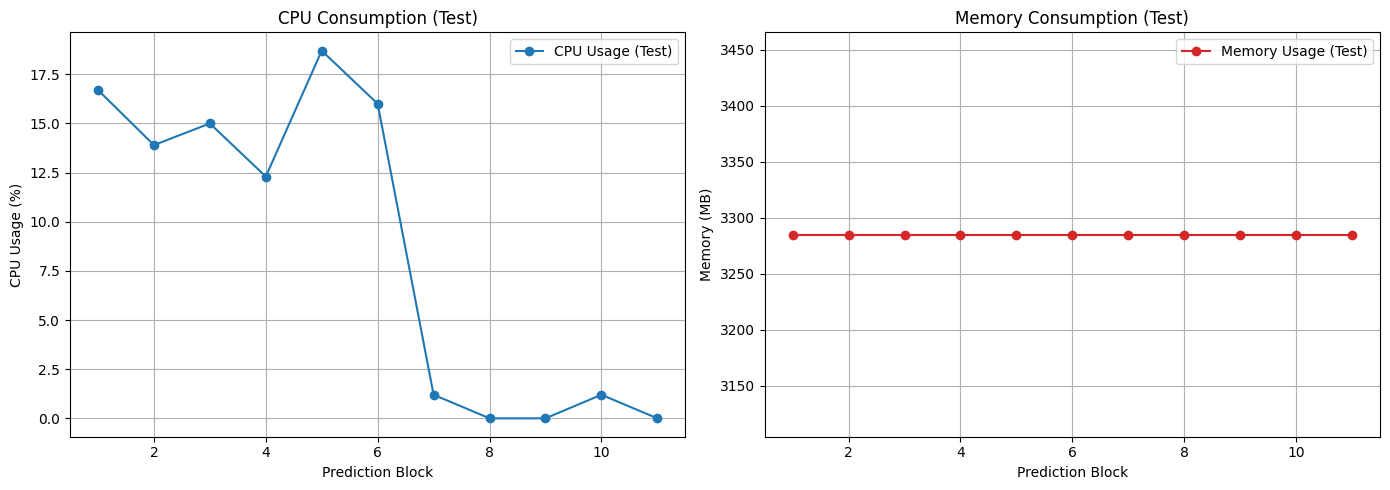


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.22 seconds
Average CPU usage (Test): 1.14%
Average memory usage (Test): 3284.95 MB
Estimated energy consumption: 14.31 Joules


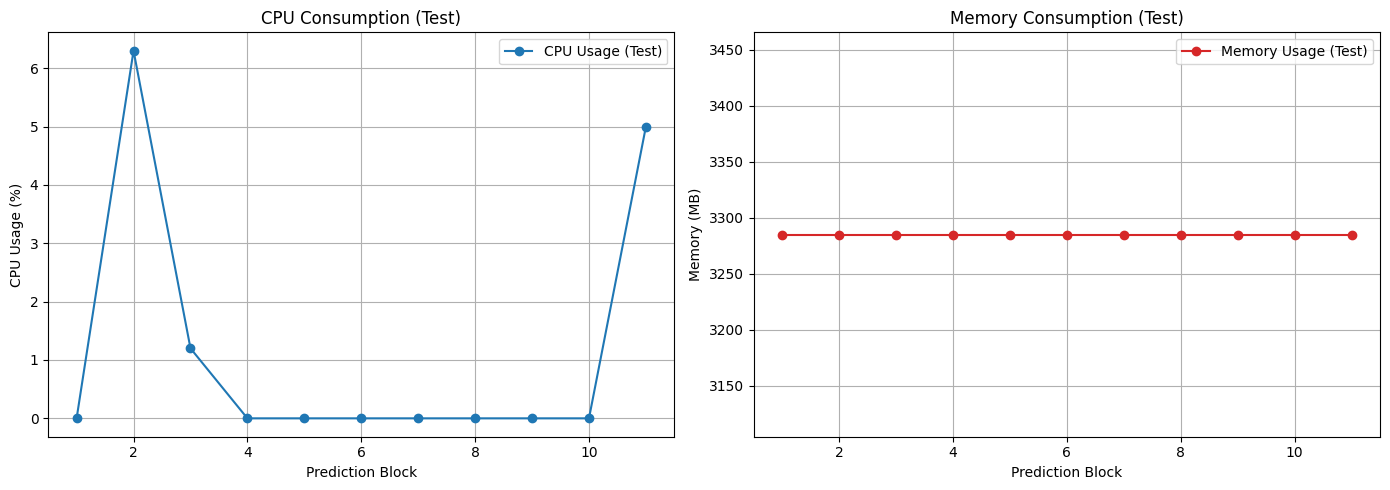

ROC FULL=0.9963
PR FULL=0.9996

====== Zero-Day: portscan_udp ======
Total portscan_udp in the original dataset: 20336
  Zero-days removed from training: 16281
  Zero-day in the original test: 4055
  Test full total: 344764

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 275.39s
CPU: 50.00%
Memory: 3353.53 MB
Energy: 2.75e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.46 seconds
Average CPU usage (Test): 1.02%
Average memory usage (Test): 3353.57 MB
Estimated energy consumption: 20.75 Joules


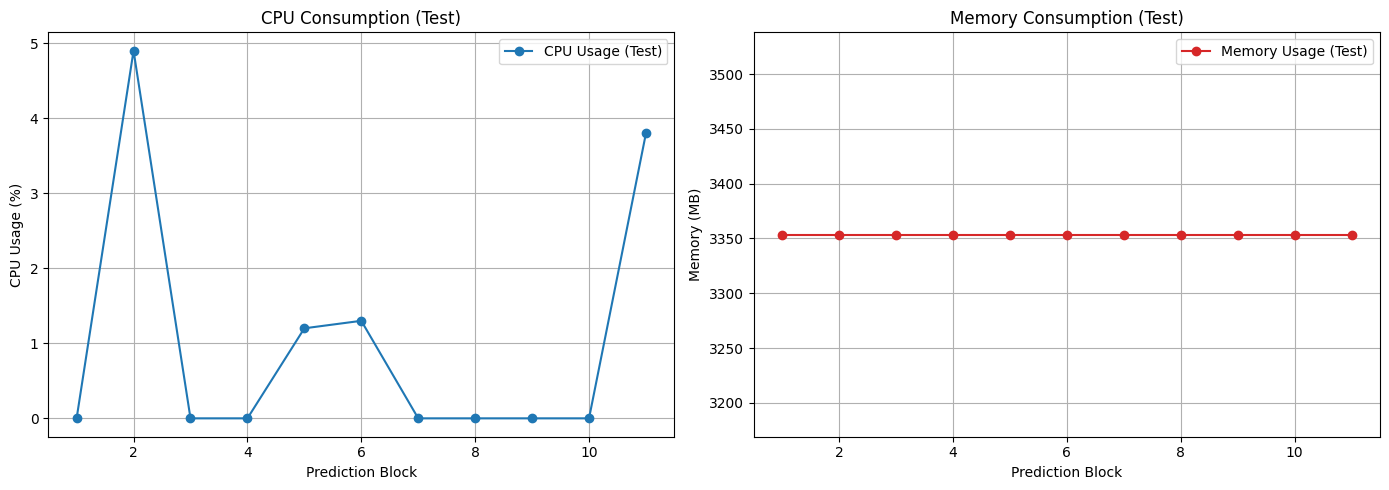


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.19 seconds
Average CPU usage (Test): 10.76%
Average memory usage (Test): 3353.57 MB
Estimated energy consumption: 11909.09 Joules


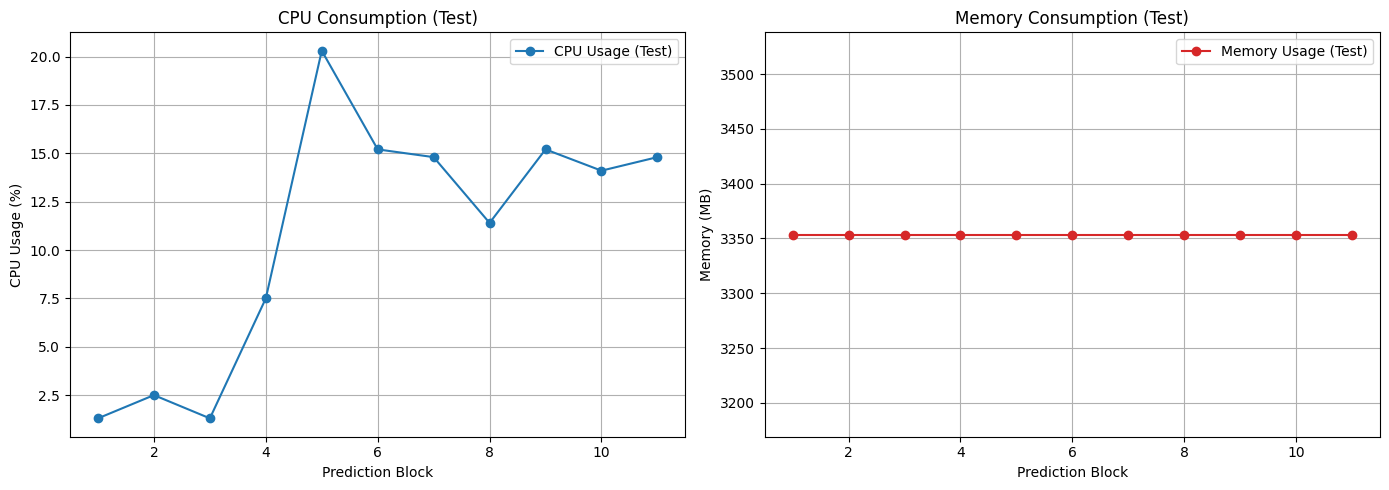

ROC FULL=0.9962
PR FULL=0.9996

====== Zero-Day: http_flood ======
Total http_flood in the original dataset: 254314
  Zero-days removed from training: 203559
  Zero-day in the original test: 50755
  Test full total: 344764

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 224.77s
CPU: 50.00%
Memory: 3178.24 MB
Energy: 2.25e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.50 seconds
Average CPU usage (Test): 0.68%
Average memory usage (Test): 3178.27 MB
Estimated energy consumption: 6.33 Joules


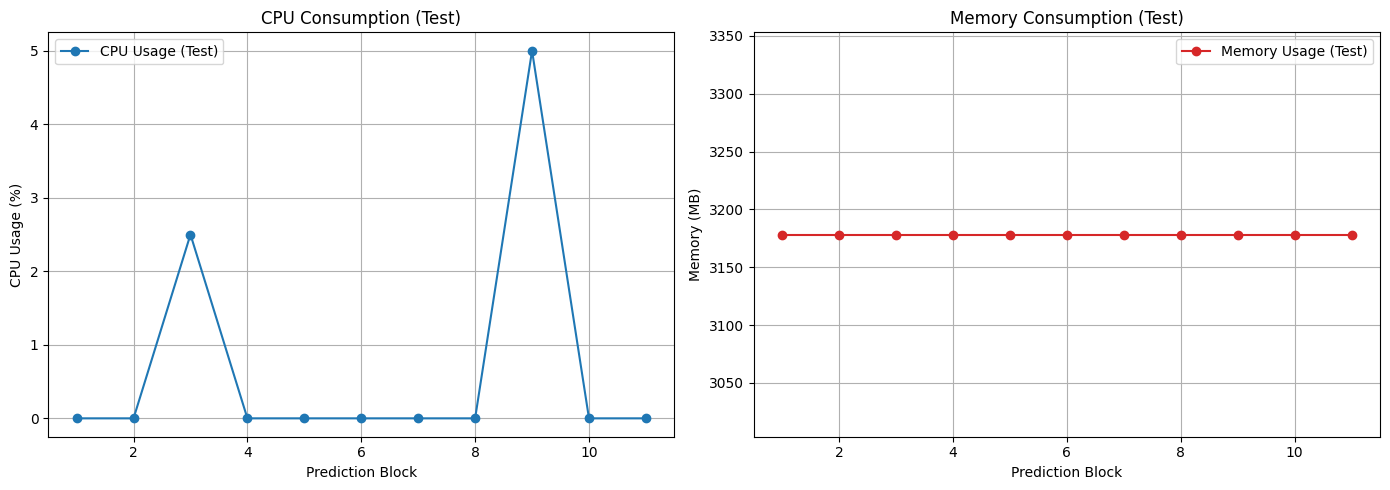


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.25 seconds
Average CPU usage (Test): 1.24%
Average memory usage (Test): 3178.27 MB
Estimated energy consumption: 18.88 Joules


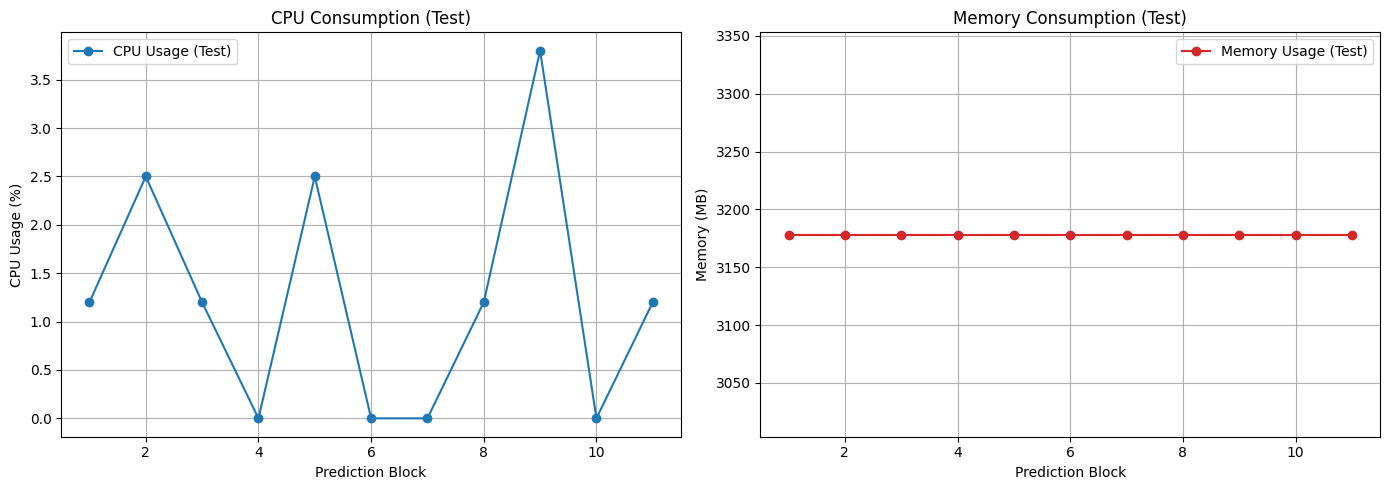

ROC FULL=0.9960
PR FULL=0.9996

====== Zero-Day: dir_bruteforce ======
Total dir_bruteforce in the original dataset: 28566
  Zero-days removed from training: 22843
  Zero-day in the original test: 5723
  Test full total: 344764

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 285.10s
CPU: 50.00%
Memory: 3288.47 MB
Energy: 2.85e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.48 seconds
Average CPU usage (Test): 0.92%
Average memory usage (Test): 3288.58 MB
Estimated energy consumption: 15.33 Joules


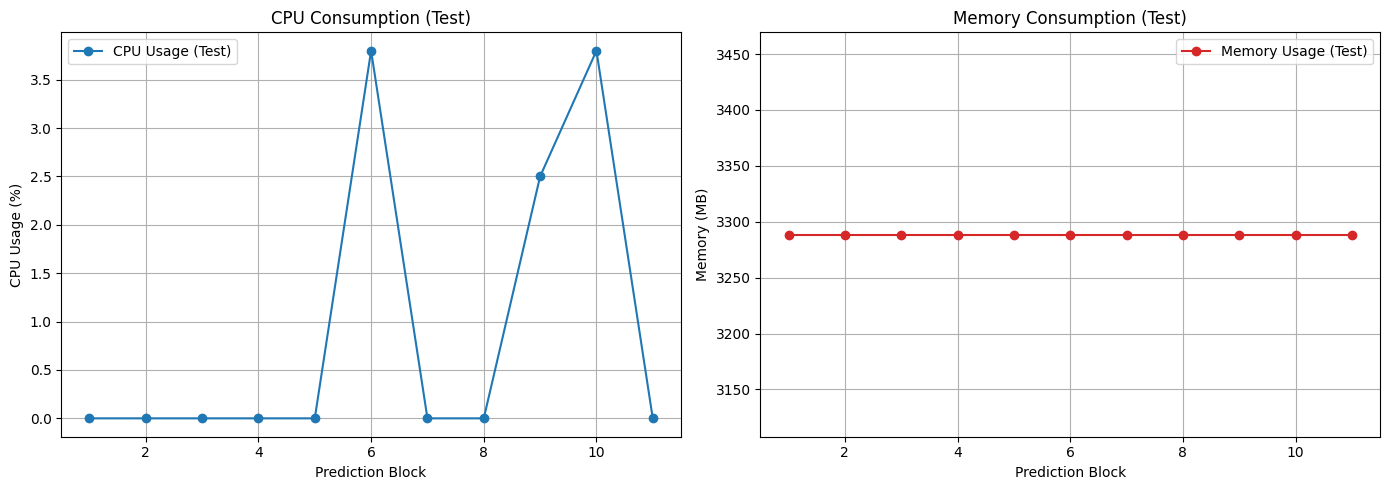


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.20 seconds
Average CPU usage (Test): 1.25%
Average memory usage (Test): 3288.58 MB
Estimated energy consumption: 18.89 Joules


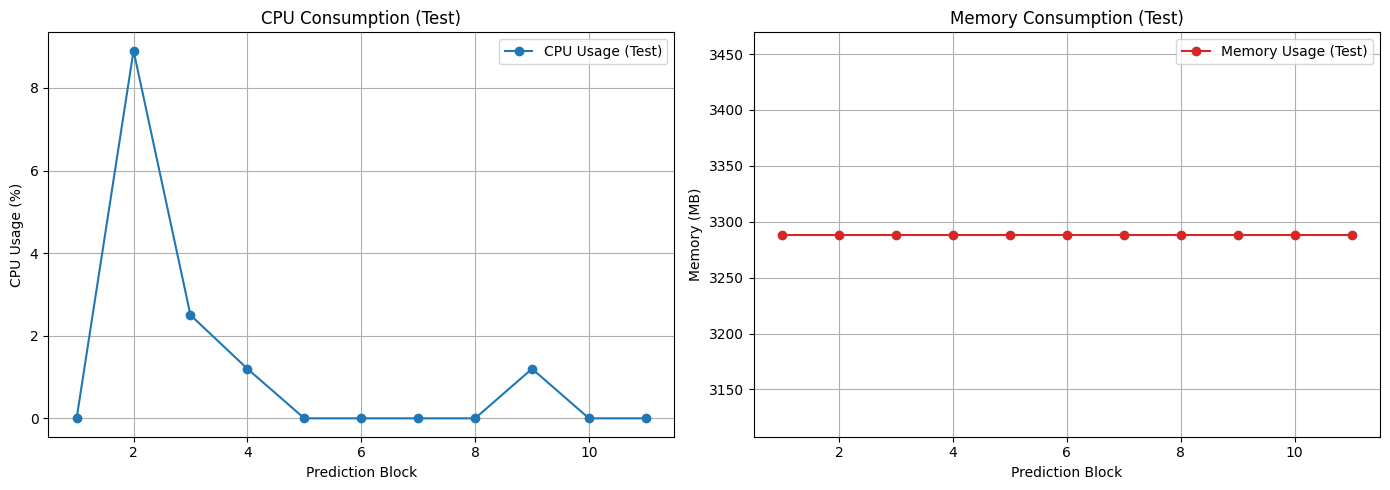

ROC FULL=0.9961
PR FULL=0.9996

====== Zero-Day: xss ======
Total xss in the original dataset: 3661
  Zero-days removed from training: 2893
  Zero-day in the original test: 768
  Test full total: 344764

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 288.01s
CPU: 50.00%
Memory: 3333.60 MB
Energy: 2.88e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.44 seconds
Average CPU usage (Test): 0.78%
Average memory usage (Test): 3333.65 MB
Estimated energy consumption: 9.31 Joules


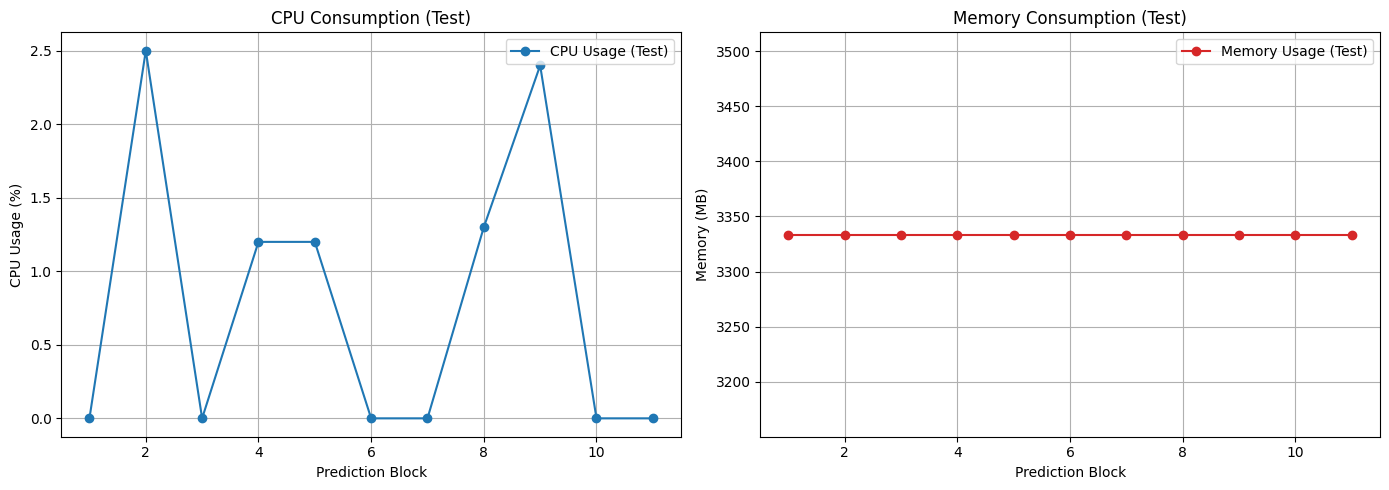


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.18 seconds
Average CPU usage (Test): 10.80%
Average memory usage (Test): 3333.65 MB
Estimated energy consumption: 11879.34 Joules


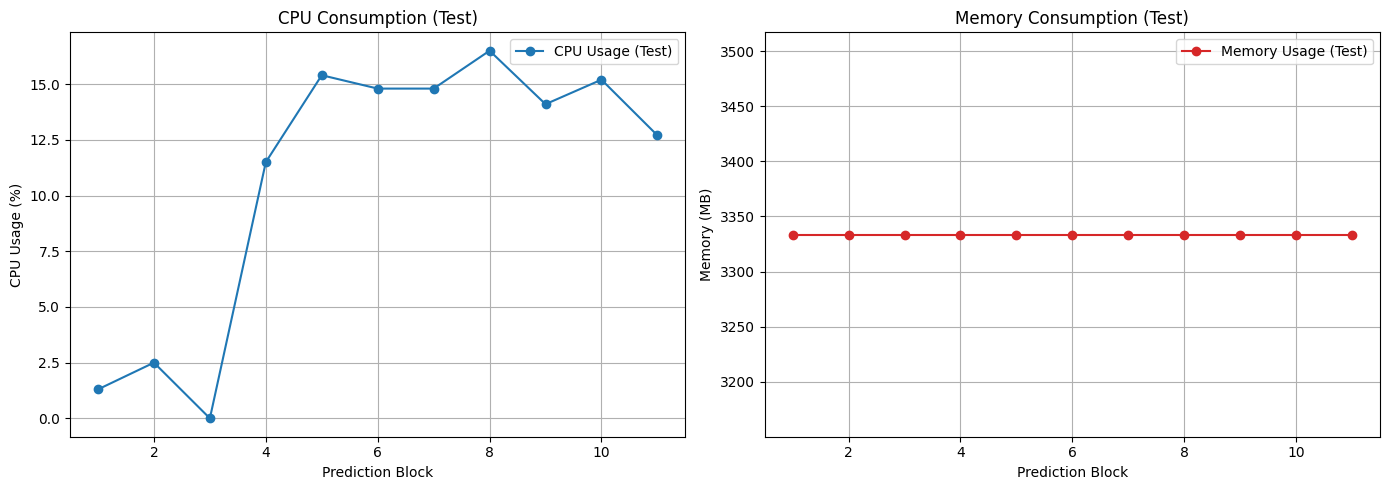

ROC FULL=0.9963
PR FULL=0.9996

====== Zero-Day: sql_injection ======
Total sql_injection in the original dataset: 1763
  Zero-days removed from training: 1427
  Zero-day in the original test: 336
  Test full total: 344764

[Start of Training - Random Forest]
[End of Training - Random Forest]
Time: 283.38s
CPU: 50.00%
Memory: 3353.13 MB
Energy: 2.83e+08 Joules

====== General Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 2.44 seconds
Average CPU usage (Test): 0.68%
Average memory usage (Test): 3353.18 MB
Estimated energy consumption: 6.20 Joules


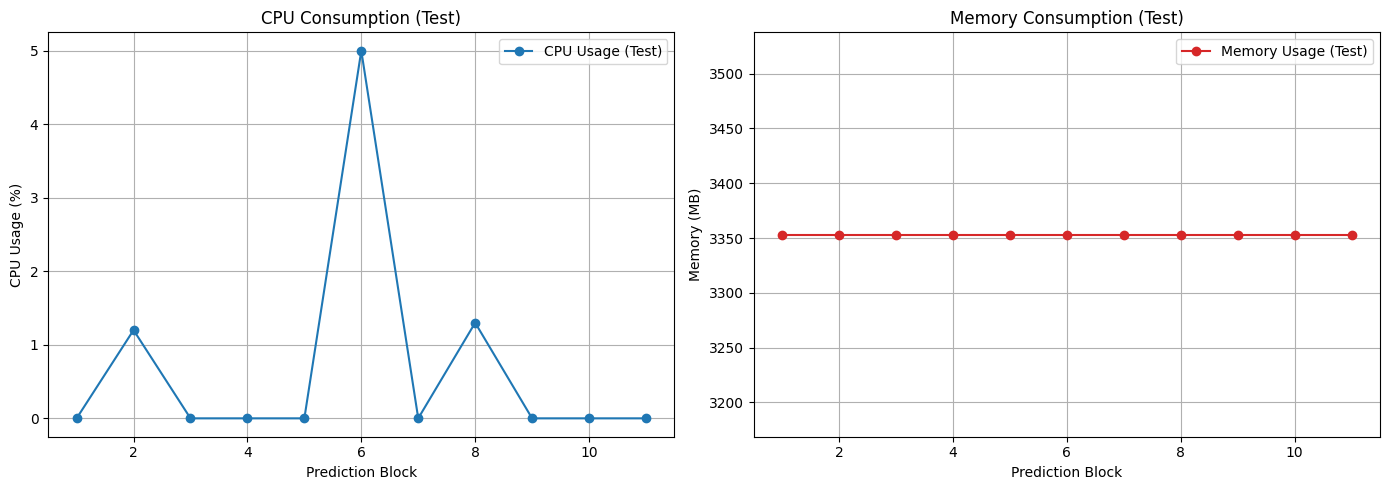


====== Zero-Day Resource Allocation ======

[Start of Prediction/Test]

[End of Prediction/Test]
Total time: 1.18 seconds
Average CPU usage (Test): 1.13%
Average memory usage (Test): 3353.18 MB
Estimated energy consumption: 13.53 Joules


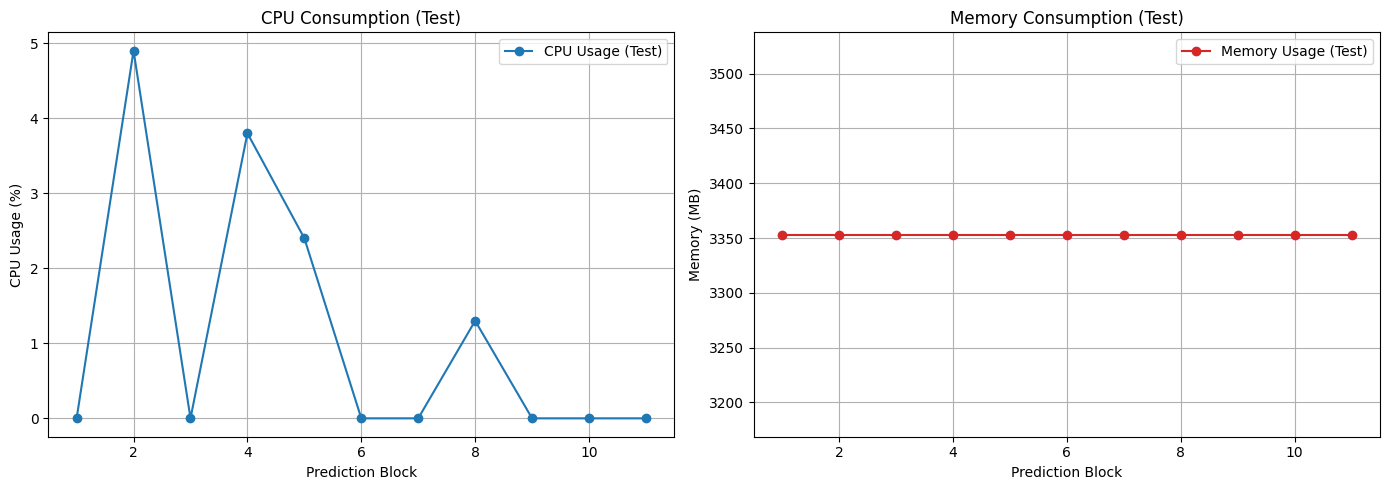

ROC FULL=0.9963
PR FULL=0.9996


In [42]:
# ===== IMPORTS =====
import pandas as pd
import numpy as np
import time
import psutil
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import os


# Configuração das features e rótulos
features = [
    'src_port', 'dst_port', 'duration', 'src_bytes', 'dst_bytes', 'missed_bytes',
    'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'ip_proto',
    'http_trans_depth', 'files_total_bytes', 'is_GET_mthd',
    'http_status_error', 'is_file_transfered', 'attack_type'
]

X = encoded[features]
y = encoded['Label']  # Coluna de rótulos

# Dividir antes de escolher zero-days
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Guardar Attack Type para separar os zero-days
X_train['attack_type'] = encoded.loc[X_train.index, 'attack_type']
X_test['attack_type'] = encoded.loc[X_test.index, 'attack_type']

# ===== CONFIGURAÇÕES =====
zero_day_attacks = ['tcp_ack', 'syn', 'icmp', 'slowloris', 'udp', 'ssh', 'ftp', 'portscan_tcp', 'os_fingerprinting', 'portscan_udp', 'http_flood', 'dir_bruteforce', 'xss', 'sql_injection']  # Adapte para os ataques que você quiser testar
smote = SMOTE(random_state=42)
scaler = StandardScaler()
label_encoder = LabelEncoder()

resultados_zero_day = []

model_name = "RandomForest"
roc_full_curves = []
pr_full_curves = []

# ===== LOOP PRINCIPAL =====
for ataque_zero_day in zero_day_attacks:
    print(f"\n====== Zero-Day: {ataque_zero_day} ======")

    # --- Contagem no dataset original ---
    total_in_original = (X['attack_type'] == ataque_zero_day).sum()
    print(f"Total {ataque_zero_day} in the original dataset: {total_in_original}")
    mask_train = X_train['attack_type'] != ataque_zero_day
    train_removed = (~mask_train).sum()

    X_train_clean = X_train.loc[mask_train].drop(columns=['attack_type']).copy()
    y_train_clean = y_train.loc[mask_train].copy()
    print(f"  Zero-days removed from training: {train_removed}")

    mask_test_zero = X_test['attack_type'] == ataque_zero_day
    X_test_zero_day = X_test.loc[mask_test_zero].drop(columns=['attack_type']).copy()
    y_test_zero_day = y_test.loc[mask_test_zero].copy()
    print(f"  Zero-day in the original test: {mask_test_zero.sum()}")

    X_test_full = X_test.drop(columns=['attack_type']).copy()
    y_test_full = y_test.copy()
    print(f"  Test full total: {len(X_test_full)}")

    # --- Balanceamento com SMOTE ---
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_clean, y_train_clean)

    # --- Normalização ---
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_full_scaled = scaler.transform(X_test_full)
    X_test_zero_day_scaled = scaler.transform(X_test_zero_day)

    # =============================
    # Codificação dos rótulos
    # =============================
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_balanced)
    y_test_full_encoded = le.transform(y_test_full)
    y_test_zero_day_encoded = le.transform(y_test_zero_day)

    # =============================
    # Treinamento do modelo
    # =============================

    model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

    recursos_rf = monitor_train_generic(model, X_train_scaled, y_train_encoded, "Random Forest")

    model.fit(X_train_scaled, y_train_encoded)

    # =============================
    # TESTE GERAL COM MONITORAMENTO
    # =============================
    print('\n====== General Resource Allocation ======')
    mstart_time = time.time()
    y_pred_full = model.predict(X_test_full_scaled)
    y_pred_full_encoded = le.transform(y_pred_full)
    metrics_test_full = monitor_test_prediction(model, X_test_full_scaled)
    acc_teste_full = accuracy_score(y_test_full_encoded, y_pred_full_encoded)
    f1_teste_full = f1_score(y_test_full_encoded, y_pred_full_encoded, zero_division=1)
    precision_full = precision_score(y_test_full_encoded, y_pred_full_encoded, zero_division=1)
    recall_full = recall_score(y_test_full_encoded, y_pred_full_encoded, zero_division=1)


    # =============================
    # TESTE ZERO-DAY COM MONITORAMENTO
    # =============================
    print('\n====== Zero-Day Resource Allocation ======')
    start_time = time.time()
    y_pred_zero_day = model.predict(X_test_zero_day_scaled)
    y_pred_zero_day_encoded = le.transform(y_pred_zero_day)
    metrics_zero_day = monitor_test_prediction(model, X_test_zero_day_scaled)
    acc_zero_day = accuracy_score(y_test_zero_day_encoded, y_pred_zero_day_encoded)
    f1_zero_day = f1_score(y_test_zero_day_encoded, y_pred_zero_day_encoded, zero_division=1)
    precision_zero = precision_score(y_test_zero_day_encoded, y_pred_zero_day_encoded, zero_division=1)
    recall_zero = recall_score(y_test_zero_day_encoded, y_pred_zero_day_encoded, zero_division=1)

    # =============================
    # Salvar resultados
    # =============================
    resultados_zero_day.append({
    'Ataque Zero-Day': ataque_zero_day,

    'Accuracy': acc_teste_full,
    'F1': f1_teste_full,
    'Precision': precision_full,
    'Recall': recall_full,
    'Time': metrics_test_full['total_time'],
    'CPU': metrics_test_full['avg_cpu'],
    'Memory': metrics_test_full['avg_mem'],
    'Energy': metrics_test_full['energia'],

    'ZD - Accuracy': acc_zero_day,
    'ZD - F1': f1_zero_day,
    'ZD - Precision': precision_zero,
    'ZD - Recall': recall_zero,
    'ZD - Time': metrics_zero_day['total_time'],
    'ZD - CPU': metrics_zero_day['avg_cpu'],
    'ZD - Memory': metrics_zero_day['avg_mem'],
    'ZD - Energy': metrics_zero_day['energia'],
})
    # =============================
    # CURVA ROC (gerada no mesmo loop)
    # =============================
    # TESTE FULL
    if hasattr(model, "predict_proba"):
        probs_full = model.predict_proba(X_test_full_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        probs_full = model.decision_function(X_test_full_scaled)
    else:
        raise AttributeError(f"O modelo {model.__class__.__name__} não possui predict_proba nem decision_function.")

    fpr_full, tpr_full, _ = roc_curve(y_test_full_encoded, probs_full)
    roc_auc_full = auc(fpr_full, tpr_full)

    roc_full_curves.append((fpr_full, tpr_full, roc_auc_full, f"{ataque_zero_day}"))

    print(f"ROC FULL={roc_auc_full:.4f}")

    # =============================
    # PR CURVE (MODELOS NORMAIS) - TESTE FULL
    # =============================

    # Geração da PR-Curve
    precision_full, recall_full, _ = precision_recall_curve(y_test_full_encoded, probs_full)
    ap_full = average_precision_score(y_test_full_encoded, probs_full)

    # Armazena
    pr_full_curves.append((precision_full, recall_full, ap_full, ataque_zero_day))

    print(f"PR FULL={ap_full:.4f}")

    del model
    gc.collect()
    K.clear_session()

/tmp/ipython-input-1070250525.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(roc_full_curves))


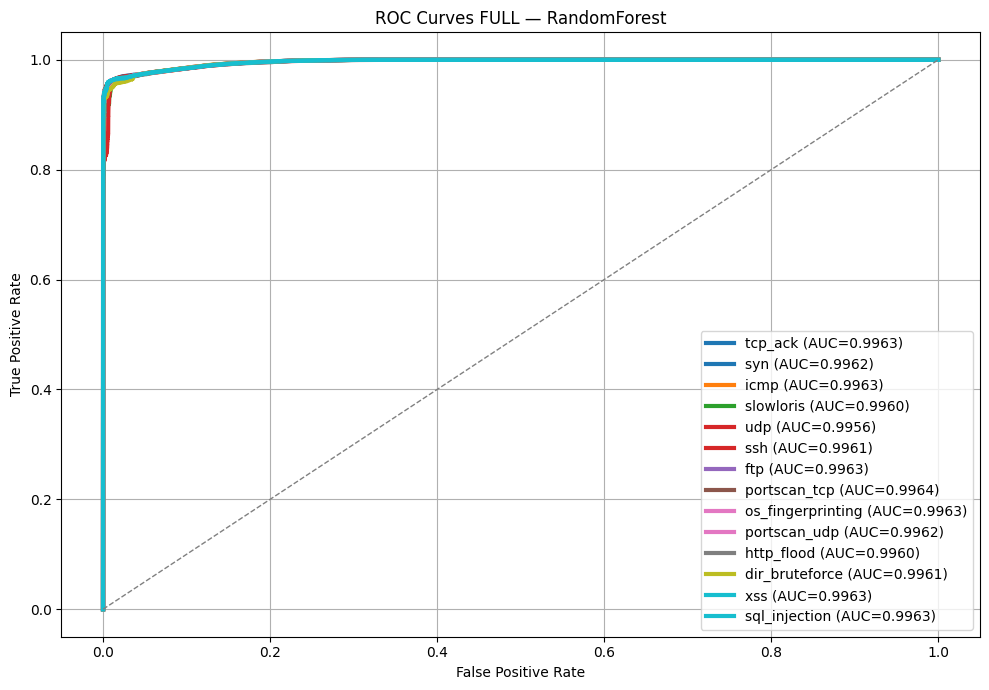

In [43]:
# =========================================
# Após o loop, gera um gráfico com todas as curvas FULL
# =========================================
plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap('tab10', len(roc_full_curves))

for i, (fpr, tpr, auc_val, label) in enumerate(roc_full_curves):
    plt.plot(fpr, tpr, lw=3, color=colors(i), label=f"{label} (AUC={auc_val:.4f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves FULL — {model_name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
os.makedirs("roc_curves", exist_ok=True)
plt.savefig(f"roc_curves/{model_name}_ALL_FULL_ROC.png", dpi=400)
plt.show()

/tmp/ipython-input-3942214508.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(pr_full_curves))


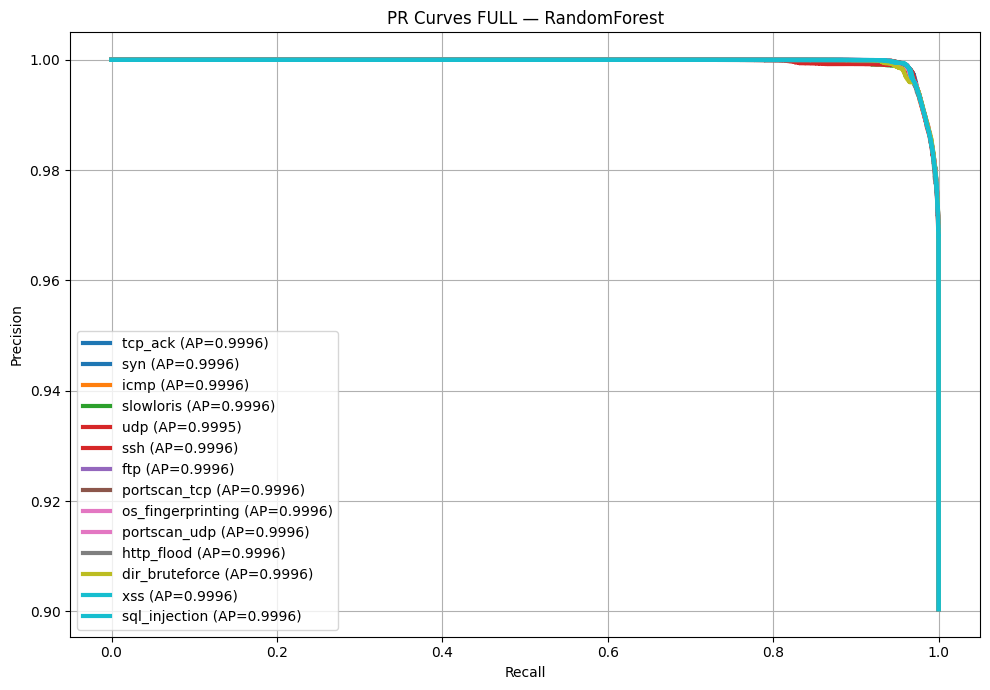

In [44]:
# =========================================
# Após o loop, gera um gráfico com todas as PR CURVES (FULL)
# =========================================
plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap('tab10', len(pr_full_curves))

for i, (precision, recall, ap_val, label) in enumerate(pr_full_curves):
    plt.plot(recall, precision, lw=3, color=colors(i),
             label=f"{label} (AP={ap_val:.4f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'PR Curves FULL — {model_name}')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()

os.makedirs("pr_curves", exist_ok=True)
plt.savefig(f"pr_curves/{model_name}_ALL_FULL_PR.png", dpi=400)
plt.show()

In [45]:
!pip install tabulate

In [46]:
import pandas as pd
from tabulate import tabulate

df_resultados = pd.DataFrame(resultados_zero_day)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 180)
pd.set_option('display.float_format', '{:.4f}'.format)

print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════════════╤════════════╤══════════╤═════════════╤══════════╤═════════╤══════════╤══════════╤══════════════╤═════════════════╤═══════════╤══════════════════╤═══════════════╤═════════════╤════════════╤═══════════════╤═══════════════╕
│ Ataque Zero-Day   │   Accuracy │       F1 │   Precision │   Recall │    Time │      CPU │   Memory │       Energy │   ZD - Accuracy │   ZD - F1 │   ZD - Precision │   ZD - Recall │   ZD - Time │   ZD - CPU │   ZD - Memory │   ZD - Energy │
╞═══════════════════╪════════════╪══════════╪═════════════╪══════════╪═════════╪══════════╪══════════╪══════════════╪═════════════════╪═══════════╪══════════════════╪═══════════════╪═════════════╪════════════╪═══════════════╪═══════════════╡
│ tcp_ack           │   0.96408  │ 0.979669 │    0.998915 │ 0.96115  │ 2.47389 │ 0.790909 │  3178.43 │     9.79151  │       0.968041  │ 0.983761  │                1 │     0.968041  │     1.29887 │   1.11818  │       3178.43 │      14.5276  │
├───────────────────┼───────────

In [47]:
df_resultados.to_csv('resultados_zero_day_formatado.csv', index=False, float_format='%.4f')